# Recommender Systems: Content-Based Filtering

This notebook is a supplementary material for the Content-Based Filtering blog post at [Encora's Insights](https://www.encora.com/insights/all). Refer to the blog post to learn more about Content-based Filtering (CBF) methods.

This notebook aims to demonstrate the strengths and limitations of Content-Based Filtering (CBF) methods using a real-world dataset (Amazon Reviews). The provided code serves as a practical example for readers to better understand the concepts discussed in the accompanying blog post.

Note: Please refer to [Preprocessing.ipynb](Preprocessing.ipynb) to see how the data must be preprocessed before proceeding with this Notebook.

# Import the libraries

In [1]:
import pandas as pd
import numpy as np
import ast
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from scipy.sparse import csr_matrix, save_npz, load_npz
import time
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dfranco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dfranco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Configurable Notebook Variables

The variables below configure the feature engineering step in this Notebook.

In [2]:
NORMALIZE_TEXT = True # if the text features should be normalized (i.e. to remove noise from the text)
SAVE_MERGE = True # if the merge between normalized metadata and reviews should be saved
CREATE_USER_PROFILE = True # whether it saves or not the resulting user profile matrix

In [3]:
kcore_5_compact_sample = pd.read_csv('dataset/kcore_5_compact_sample.csv', names=['reviewerID', 'asin', 'overall'], quotechar='"') 
meta = pd.read_csv('dataset/metadata_sample.csv', names=['asin', 'categories', 'title', 'description', 'related'], converters={'categories': pd.eval}, quotechar='"')

# Feature Engineering

Before jumping into the content-based recommender system, we still need to perform some data transformations.

In [4]:
print(kcore_5_compact_sample.dtypes)
kcore_5_compact_sample['overall'] = kcore_5_compact_sample['overall'].astype('int')
print()
kcore_5_compact_sample.head()

reviewerID    object
asin          object
overall        int64
dtype: object



,reviewerID,asin,overall
0,A2HWI21H23GDS4,0000589012,4
1,A20BIPRPD473RD,000100039X,5
2,A9WX8DK93SN5,000100039X,1
3,A2OKG8UA0G4OXS,000100039X,5
4,AU837CQMP7EDF,000100039X,5


**Distribution of ratings**

array([[<AxesSubplot:title={'center':'overall'}>]], dtype=object)

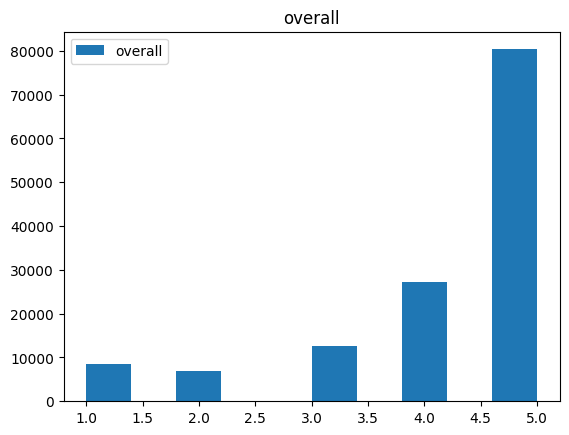

In [5]:
kcore_5_compact_sample.hist(column='overall', legend='True', grid=False)

In this Notebook, we will mostly work with the metadata attributes because it contains text attributes for product descriptions. The text will be leveraged to find products with similar descriptions to products the user already likes.

Here's a preview of the data:

In [6]:
print(meta.dtypes)
meta.head()

asin           object
categories     object
title          object
description    object
related        object
dtype: object


,asin,categories,title,description,related
0,0000589012,"[[Movies & TV, Movies]]",Why Don't They Just Quit? DVD Roundtable Discu...,NaN,"{'also_bought': ['B000Z3N1HQ', '0578045427', '..."
1,000100039X,[[Books]],The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '..."
2,0002051850,[[Books]],For Whom the Bell Tolls,NaN,"{'also_bought': ['0684801469', '0743297334', '..."
3,0002007770,[[Books]],Water For Elephants,NaN,"{'also_bought': ['0399155341', '1573222453', '..."
4,0002247399,[[Books]],A Dance with Dragons,NaN,"{'also_bought': ['0553801503', '0553106635', '..."


To simplify this process, we will only concatenate some text attributes, *category* and *title*, to extract relevant information from text, but first we will handle the features separately.

In [7]:
meta['categories'] = meta['categories'].apply(lambda x: ', '.join([elem for list_elem in x for elem in list_elem])).astype(str)
meta['related'] = meta['related'].apply(lambda x: ast.literal_eval(x) if not pd.isnull(x) else None)
meta[['categories', 'related']].head()

,categories,related
0,"Movies & TV, Movies","{'also_bought': ['B000Z3N1HQ', '0578045427', '..."
1,Books,"{'also_bought': ['1851686274', '0785830618', '..."
2,Books,"{'also_bought': ['0684801469', '0743297334', '..."
3,Books,"{'also_bought': ['0399155341', '1573222453', '..."
4,Books,"{'also_bought': ['0553801503', '0553106635', '..."


Now we merge the title and categories into a single *content* feature. This content feature contains important keywords that could be shared between different products. Other text fields can be used, such as description, but for this demonstration, we will simplify and use features with less "random" text.

In [8]:
meta['content'] = meta['title'] + ' ' + meta['categories']

## Normalization

At this stage, the content attribute will be normalized to remove text information that is noise to Machine Learning models. More specifically, we remove punctuations, numbers, stop words (e.g. the, a, etc.) and then perform stemming to reduce inflection in words to their root forms (e.g. transforms verb inflections such as "stops" and "stopping" to "stop".)

In [9]:
def remove_punctuation(word):
    return ''.join([char if not unicodedata.category(char).startswith('P') else '' for char in word])

def remove_number(word): 
    try:
        w = int(word)
        return ''
    except ValueError:
        return word

def normalize_corpus(content_series):
    stemmer = PorterStemmer()
    words_to_filter = list(set(stopwords.words('english')))
    words_to_filter.extend(['amp', '&amp', 'quot', '&quot'])

    return content_series.apply(lambda x: ' '.join([remove_number(remove_punctuation(stemmer.stem(word)))
                                                   for sentence in nltk.tokenize.sent_tokenize(x.lower())
                                                   for word in nltk.tokenize.word_tokenize(sentence)
                                                   if word not in words_to_filter]))

def normalize_text(content_text):
    stemmer = PorterStemmer()
    words_to_filter = list(set(stopwords.words('english')))
    words_to_filter.extend(['amp', '&amp', 'quot', '&quot'])

    return ' '.join([remove_number(remove_punctuation(stemmer.stem(word)))
        for sentence in nltk.tokenize.sent_tokenize(content_text.lower())
        for word in nltk.tokenize.word_tokenize(sentence)
        if word not in words_to_filter])

if NORMALIZE_TEXT:
    meta['norm_content'] = normalize_corpus(meta['content'])
    meta.to_json('dataset/metadata_normalized_sample.json', orient='records', lines=True)
    
meta = pd.read_json('dataset/metadata_normalized_sample.json', lines=True)
meta.head()

,asin,categories,title,description,related,content,norm_content
0,0000589012,"Movies & TV, Movies",Why Don't They Just Quit? DVD Roundtable Discu...,None,"{'also_bought': ['B000Z3N1HQ', '0578045427', '...",Why Don't They Just Quit? DVD Roundtable Discu...,nt quit dvd roundtabl discuss famili friend ...
1,000100039X,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '...",The Prophet Books,prophet book
2,0002051850,Books,For Whom the Bell Tolls,None,"{'also_bought': ['0684801469', '0743297334', '...",For Whom the Bell Tolls Books,bell toll book
3,0002007770,Books,Water For Elephants,None,"{'also_bought': ['0399155341', '1573222453', '...",Water For Elephants Books,water eleph book
4,0002247399,Books,A Dance with Dragons,None,"{'also_bought': ['0553801503', '0553106635', '...",A Dance with Dragons Books,danc dragon book


## Vectorization

This stage aims to transform the normalized text into a vector of numbers that can be interpreted by the Machine Learning model.

For the purpose of this work, we utilize TF-IDF to create a numerical representation for the text data. Remember TF-IDF is:


$ \large TF(t, i) = \frac{Frequency\ of\ term\ t\ in\ item\ i}{Total\ number\ of\ terms\ in\ item\ i}$

$ \large IDF(t) = log(\frac{Total\ number\ of\ items}{Number\ of\ items\ i\ that\ contains\ the\ term\ t}) + 1$

$ \large TF-IDF(t, i) = TF(t, i) * IDF(t)$

The scikit-learn implementation of TF-IDF may differ slightly from the formula presented above, but the overall objective remains the same. Despite this, the formula provided above is useful as it presents the concept in a clear and easy way to understand.

In [10]:
meta = meta.reset_index(drop=True) # start index from 0 
item_list = []
corpus = []
for idx, row in meta.iterrows():
    corpus.append(row['norm_content']) # list of normalized texts
    item_list.append(row['asin'] )

item_to_idx = pd.Series(data=[idx for idx in range(0,len(item_list))], index=item_list, dtype=int)
idx_to_item = pd.Series(data=[item for item in item_list]) 
item_vectorizer = TfidfVectorizer(min_df=5, max_df=0.6)
item_word_matrix = item_vectorizer.fit_transform(corpus)
tokens_array = item_vectorizer.get_feature_names_out()

Number of words in this corpus' vocabulary.

In [11]:
tokens_array.shape

(12153,)

The item-word matrix shows, for each sentence (the product's text content) in the corpus, the corresponding index of the word and its importance (weight) on the sentence.

In [12]:
print(item_word_matrix)

  (0, 11276)	0.14486224699076536
  (0, 7290)	0.2960269007900051
  (0, 8931)	0.33484558424978084
  (0, 874)	0.3278615748304104
  (0, 6220)	0.2714172705266525
  (0, 7468)	0.2769108271492628
  (0, 4659)	0.2602717856593979
  (0, 4270)	0.24364229752473507
  (0, 3552)	0.3743875229794133
  (0, 3807)	0.23871059904028208
  (0, 8776)	0.3646436636287281
  (0, 7654)	0.25338615687542027
  (1, 1895)	0.23650603412816712
  (1, 8629)	0.971630020028697
  (2, 11026)	0.7912256917620408
  (2, 1645)	0.5862328730356311
  (2, 1895)	0.17404862328691278
  (3, 3943)	0.8339049946195589
  (3, 11745)	0.5094275041261728
  (3, 1895)	0.21233482518967955
  (4, 3685)	0.7554193215878935
  (4, 3260)	0.6116358175251682
  (4, 1895)	0.23503888038366375
  (5, 11925)	0.955932585676094
  (5, 1895)	0.29358625928782395
  :	:
  (87847, 4983)	0.1660964706522944
  (87847, 4585)	0.16195609524985344
  (87847, 11635)	0.12550105390018185
  (87847, 1936)	0.2089071837952601
  (87847, 2299)	0.07954387941375825
  (87847, 5397)	0.19924755218

# Joining reviews and product metadata

After feature engineering, we merge the reviews with the metadata's normalized content attribute.

In [13]:
try:
    reviews = pd.read_json('dataset/reviews_meta.json', lines=True)    
except ValueError:
    reviews = kcore_5_compact_sample[['reviewerID', 'asin', 'overall']].merge(meta, on='asin', how='inner')

if SAVE_MERGE:
    reviews.to_json('dataset/reviews_meta.json', orient='records', lines=True)

reviews.head()

,reviewerID,asin,overall,categories,title,description,related,content,norm_content
0,A2HWI21H23GDS4,0000589012,4,"Movies & TV, Movies",Why Don't They Just Quit? DVD Roundtable Discu...,None,"{'also_bought': ['B000Z3N1HQ', '0578045427', '...",Why Don't They Just Quit? DVD Roundtable Discu...,nt quit dvd roundtabl discuss famili friend ...
1,A20BIPRPD473RD,000100039X,5,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '...",The Prophet Books,prophet book
2,A9WX8DK93SN5,000100039X,1,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '...",The Prophet Books,prophet book
3,A2OKG8UA0G4OXS,000100039X,5,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '...",The Prophet Books,prophet book
4,AU837CQMP7EDF,000100039X,5,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '...",The Prophet Books,prophet book


In [14]:
print(len(reviews))
reviews.head()

108929


,reviewerID,asin,overall,categories,title,description,related,content,norm_content
0,A2HWI21H23GDS4,0000589012,4,"Movies & TV, Movies",Why Don't They Just Quit? DVD Roundtable Discu...,None,"{'also_bought': ['B000Z3N1HQ', '0578045427', '...",Why Don't They Just Quit? DVD Roundtable Discu...,nt quit dvd roundtabl discuss famili friend ...
1,A20BIPRPD473RD,000100039X,5,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '...",The Prophet Books,prophet book
2,A9WX8DK93SN5,000100039X,1,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '...",The Prophet Books,prophet book
3,A2OKG8UA0G4OXS,000100039X,5,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '...",The Prophet Books,prophet book
4,AU837CQMP7EDF,000100039X,5,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '...",The Prophet Books,prophet book


Let's examine the items that have received the highest rating (5) the most in this sampled dataset.

In [15]:
top_items_df = reviews[reviews['overall'] == 5].groupby('asin').size().sort_values(ascending=False)
top_n = 15
top_n_items = pd.DataFrame({'asin': top_items_df[:top_n].index, 'count': top_items_df[:top_n].values})
meta.merge(top_n_items, on='asin', how='inner').sort_values(by='count', ascending=False)[['asin', 'title', 'categories', 'count']]

,asin,title,categories,count
11,B0074BW614,"Kindle Fire HD 7&quot;, Dolby Audio, Dual-Band...","Electronics, eBook Readers & Accessories, eBoo...",33
12,B007WTAJTO,SanDisk Ultra 64GB MicroSDXC Class 10 UHS Memo...,"Electronics, Computers & Accessories, Cables &...",26
2,0439023483,"The Hunger Games (The Hunger Games, Book 1)",Books,24
8,B003ES5ZUU,AmazonBasics High-Speed HDMI Cable - 15 Feet (...,"Electronics, Accessories & Supplies, Audio & V...",21
13,B0090YGJ4I,OtterBox Defender Series Case for iPhone 5 (Di...,"Cell Phones & Accessories, Cases, Basic Cases",20
0,0007386648,Unbroken,Books,19
10,B005SUHPO6,Otterbox Defender Series Hybrid Case &amp; Hol...,"Cell Phones & Accessories, Cases, Basic Cases",19
6,B0019EHU8G,Mediabridge ULTRA Series HDMI Cable (6 Feet) -...,"Electronics, Accessories & Supplies, Audio & V...",18
9,B004S8F7QM,Cards Against Humanity,"Toys & Games, Games, Card Games",18
5,1608838137,Masterpiece Classic: Downton Abbey Season 3,"Movies & TV, TV",17


# User profiles

Next, we will create user profiles for the reviewers. These profiles are created by leveraging the textual information of the products reviewed by the user, which can be useful for discovering patterns of what kind of products the user might like.

Basically, for each reviewer, we find a vector of weights for the words in the vocabulary, which reflect the significance of that word to that specific user, based on the products they have previously rated. This vector is constructed by taking the average of the review ratings multiplied by the attributes (words) of the product, and it will represent the profile that will be later used for recommendations. 

The Scipy's sparse matrices are used here to efficiently compute the linear algebra operations without having to store all the 0s in the matrix.

In [16]:
if 'index' not in reviews.columns:
    reviews = reviews.reset_index()
user_group = reviews.groupby('reviewerID', sort=False)
unique_users = user_group.size().to_frame('count').reset_index()
max_rating = reviews['overall'].max()

if CREATE_USER_PROFILE:
    start = time.time()
    ratings = user_group['overall'].apply(np.array)
    grouped_indices = user_group['index'].apply(np.array)
    num_reviews_per_user = csr_matrix(1 / user_group['overall'].apply(len)).T

    weights_rows = list()
    weights_cols = list()
    weights_data = list()
    user_list = list()
    idx_list = list()

    offset = 0
    
    weights_rows.append(offset)
    for idx, row in unique_users.iterrows():
        weights_cols.extend(grouped_indices.iloc[idx])
        weights_data.extend(((1/max_rating) * ratings.iloc[idx]).tolist())
        offset = offset + grouped_indices.iloc[idx].shape[0]
        weights_rows.append(offset)
        user_list.append(row['reviewerID'])

    user_item_matrix = item_vectorizer.transform(reviews['norm_content'])
    weights = csr_matrix((weights_data, weights_cols, weights_rows), shape=(unique_users.shape[0], user_item_matrix.shape[0]), 
                         dtype=np.float64)
    user_profile = (weights.dot(user_item_matrix)).multiply(num_reviews_per_user)
    user_to_idx = pd.Series(data=[idx for idx in list(unique_users.index)], index=user_list, dtype=int)
    
    save_npz('dataset/user_profile.npz', user_profile)
    user_to_idx.to_csv('dataset/user_to_idx.csv')
    end = time.time()
    print('Runtime: ', end - start)

user_profile = load_npz('dataset/user_profile.npz')
user_to_idx = pd.read_csv('dataset/user_to_idx.csv', index_col = 0).squeeze("columns")

Runtime:  2.3184804916381836


# Running recommendations with a Content-based Recommender System

Now it is time to put the newly created user profiles into use!

We will use some examples in the dataset and try to match with other products (items). In this sense, the items with the most similar text content to the query will be recommended.


## Recommending items based on the similarity between text contents

First, we get an example from the dataset to use as a query. In this case, we select an example that includes "Google Nexus 5" in its text content. Since the example is from the category "Cell phones", we expect some products from that category to be recommended.

In [17]:
reviews[reviews['content'].apply(lambda x: 'Google Nexus 5' in x)]

,index,reviewerID,asin,overall,categories,title,description,related,content,norm_content
101569,101569,A5MJHLCUFN45U,B00A5UFOQU,5,"Cell Phones & Accessories, Cases, Armbands","High Quality Armband for HTC DROID DNA, HTC On...",Features adjustable (hook and loop) strap for ...,"{'also_bought': ['B00HX3G6J6', 'B00J902ZXM', '...","High Quality Armband for HTC DROID DNA, HTC On...",high qualiti armband htc droid dna htc one m...
102348,102348,A44PHK49RBWFO,B00AOW8I30,5,"Cell Phones & Accessories, Cases, Basic Cases",Caseology Google Nexus 5 [Carbon Fiber Hybrid]...,We believe great products are made greater by ...,"{'also_bought': ['B00FPQUZH2', 'B00FEZOX36', '...",Caseology Google Nexus 5 [Carbon Fiber Hybrid]...,caseolog googl nexu carbon fiber hybrid pr...
104367,104367,A34CSXOGVYF94S,B00C13YSIO,5,"Cell Phones & Accessories, Accessories, Batter...",Maxboost Electron 10000mAh Dual-port 3A Premiu...,About Maxboost Electron:Featuring an advanced ...,"{'also_bought': ['B00ISGCAJM', 'B00HZWJGS8', '...",Maxboost Electron 10000mAh Dual-port 3A Premiu...,maxboost electron 10000mah dualport 3a premium...
107034,107034,A3K8G6TK9BH37T,B00EPLTC1I,4,"Cell Phones & Accessories, Cases, Basic Cases",[BETTER GRIP] RINGKE SLIM&reg; Google Nexus 5 ...,Rearth offers a simple 1 piece hard case that ...,"{'also_bought': ['B00EPLT8O4', 'B00G200KQQ', '...",[BETTER GRIP] RINGKE SLIM&reg; Google Nexus 5 ...,better grip ringk slim reg googl nexu cas...
107518,107518,A1D8A49VYEZPH7,B00FGONRZK,5,"Cell Phones & Accessories, Accessories, Car Ac...",Aibocn&reg; Universal Portable and Adjustable ...,Limited Time Sale: ONLY $8.99 for Aibocn porta...,"{'also_bought': ['B00GSC6HDI', 'B00F9HWPVQ', '...",Aibocn&reg; Universal Portable and Adjustable ...,aibocn reg univers portabl adjust tablet cel...
107553,107553,AEUR6WVTQXRYE,B00FJJ38HY,3,"Cell Phones & Accessories, Cases, Basic Cases","Nexus 5 Case, Spigen&reg; [AIR CUSHION] [+Scre...",Compatible with ALL versions of the Nexus 5SPI...,"{'also_bought': ['B00EV97UD6', 'B00GG63522', '...","Nexus 5 Case, Spigen&reg; [AIR CUSHION] [+Scre...",nexu case spigen reg air cushion +scree...
107554,107554,A37BVM0O7RSIIR,B00FJJ38HY,5,"Cell Phones & Accessories, Cases, Basic Cases","Nexus 5 Case, Spigen&reg; [AIR CUSHION] [+Scre...",Compatible with ALL versions of the Nexus 5SPI...,"{'also_bought': ['B00EV97UD6', 'B00GG63522', '...","Nexus 5 Case, Spigen&reg; [AIR CUSHION] [+Scre...",nexu case spigen reg air cushion +scree...
107760,107760,A3I9K8W0E1UZYA,B00FXYG5UM,5,"Cell Phones & Accessories, Cases, Basic Cases",Hyperion LG Google Nexus 5 Explorer Hybrid Cas...,Be sure to search for other products offered b...,"{'also_viewed': ['B00GBZLQ8S', 'B00FXCTR8G', '...",Hyperion LG Google Nexus 5 Explorer Hybrid Cas...,hyperion lg googl nexu explor hybrid case co...
107897,107897,A17WUA423SAERP,B00GB636EY,5,"Cell Phones & Accessories, Cases, Basic Cases",GreatShield Legacy Series Ultra Slim Fit Dual ...,GreatShield Legacy Series Ultra Slim Fit Dual ...,"{'also_bought': ['B00GYEG3U2', 'B00GNQQNTW', '...",GreatShield Legacy Series Ultra Slim Fit Dual ...,greatshield legaci seri ultra slim fit dual la...
107911,107911,A3EK21Q1YGNTTG,B00GBRMOS2,5,"Cell Phones & Accessories, Cases, Basic Cases,...",IZENGATE Elegant Floral Skin Premium PU Leathe...,Protect and personalize your phone with this s...,"{'also_bought': ['B00EPLT8O4', 'B00FEZOX36', '...",IZENGATE Elegant Floral Skin Premium PU Leathe...,izeng eleg floral skin premium pu leather wall...


We will select one of the examples. In this case, product with ID B00GD6H0NU.

In [18]:
reviews[reviews['asin'] == 'B00GD6H0NU']['content'].iloc[0]

'Google Nexus 5 D820 Unlocked GSM Phone, 32Gb (Black) Cell Phones & Accessories, Cell Phones, Unlocked Cell Phones'

Now, get the indices from the item-word matrix for this item and then print the words just to check how the normalized content looks like. 

In [19]:
item_tokens_indices = item_word_matrix[item_to_idx['B00GD6H0NU']].nonzero()[1]
tokens_array[item_tokens_indices]

array(['d820', '32gb', 'gsm', 'nexu', 'accessori', 'googl', 'unlock',
       'phone', 'cell', 'black'], dtype=object)

Next we recommend the top 10 items with the most similar content to B00GD6H0NU. The cosine similarity is used as a measure for how similar the items are.

In [20]:
query_vector = item_word_matrix[item_to_idx['B00GD6H0NU']]
similarities = cosine_similarity(query_vector, item_word_matrix)[0]
similar_items_indices = np.argsort(similarities)[::-1][1:top_n+1]
idx_to_item[similar_items_indices].values

array(['B00ABPKHH0', 'B003A4HWYU', 'B009IRGQPO', 'B004P8JL76',
       'B00CKUBLFQ', 'B00HHZWO78', 'B00FZV14GI', 'B00K0NRVNG',
       'B007Z4ZT46', 'B0037VGDEG', 'B00ASYZWNI', 'B00GWR36F6',
       'B003HC8GEA', 'B00AR23T5O', 'B0025W5RX6'], dtype=object)

In [21]:
meta.iloc[similar_items_indices]['title']

81797    LG E960 Google Nexus 4 Unlocked GSM Phone 16GB...
60288                Motorola BACKFLIP with Motoblur Phone
80581    LG A275 Black Unlocked GSM Dual SIM QuadBand C...
67600    Nokia X2-01 Unlocked GSM Phone-U.S. Version wi...
84454    Nokia Lumia 520 8GB Unlocked GSM Windows 8 OS ...
87373                 BLU Life Pure Unlocked Phone (Black)
86815    BLU Dash 5.0 D410a Unlocked Dual SIM  GSM Phon...
87819    Motorola Moto E - US GSM - Unlocked - 4GB (Black)
77004    Motorola EX226 Black Dual SIM Unlocked GSM Qua...
59953    Nokia 7020 Unlocked Cell Phones--US Version wi...
82381    Sony Xperia E C1604 Dual-SIM Unlocked Android ...
87194    Motorola Moto G - Global GSM - Unlocked - 8GB ...
61328    Samsung E1080 Unlocked Dual-Band GSM Phone - I...
82313    Nokia Lumia 920 Black Factory Unlocked 32GB ph...
54658    Samsung SGH-A877 Impression 3G GSM Cell Phone ...
Name: title, dtype: object

Notice how it recommends cell phones, the same category of the query product.

Now let's wrap up the item-item recommendation in a function:

In [22]:
def recommend_similar_item_asin(asin_query, top_n=10):
    query_vector = item_word_matrix[item_to_idx[asin_query]]
    similarities = cosine_similarity(query_vector, item_word_matrix)[0]
    similar_items_indices = np.argsort(similarities)[::-1][1:top_n+1]
    return meta.iloc[similar_items_indices][['asin','related','title','categories','norm_content']]

def recommend_similar_items_txt(content_text, top_n):
    corpus = [normalize_text(content_text)]
    query_item = item_vectorizer.transform([content_text])
    similarities = cosine_similarity(query_item, item_word_matrix)[0]
    similar_items_indices = np.argsort(similarities)[::-1][:top_n]
    return meta.iloc[similar_items_indices][['asin','related','title','categories','norm_content']]

Let's try these new functions and recommend similar items to 'Panasonic RPHJE120D In-Ear Headphone, Orange':

In [23]:
asin = 'B003ELYQGG'
print(meta[meta['asin'] == asin]['title'])
recommend_similar_item_asin(asin, 3)

61007    Panasonic RPHJE120D In-Ear Headphone, Orange
Name: title, dtype: object


,asin,related,title,categories,norm_content
61009,B003EM6AOG,"{'also_bought': ['B007CT7TAQ', 'B00EK5O66U', '...","Panasonic RPHJE120A In-Ear Headphone, Blue","Electronics, Accessories & Supplies, Audio & V...",panason rphje120a inear headphon blue electro...
52862,B001MQ8BL6,"{'also_viewed': ['B00AWLEAH6', 'B007NPVE2S', '...",HiFiMan RE-0 In-Ear Stereo Headphones,"Electronics, Accessories & Supplies, Audio & V...",hifiman re0 inear stereo headphon electron ac...
57111,B002NSWN7A,"{'also_viewed': ['B00AWLEAH6', 'B007NPVE2S', '...",HiFiMan - RE-ZERO - In-Ear Stereo Headphones,"Electronics, Accessories & Supplies, Audio & V...",hifiman rezero inear stereo headphon electro...


As you can see, relating products are recommended.

Next, let's predict similar items to a item that is not present in the 2014 dataset.

In [24]:
item_content = 'SanDisk 1TB Extreme Portable SSD - Up to 1050MB/s - USB-C, USB 3.2 Gen 2 - External Solid State Drive - SDSSDE61-1T00-G25 ' \
+ 'Computers & Accessories'
print(item_content)
recommend_similar_items_txt(item_content, 3)

SanDisk 1TB Extreme Portable SSD - Up to 1050MB/s - USB-C, USB 3.2 Gen 2 - External Solid State Drive - SDSSDE61-1T00-G25 Computers & Accessories


,asin,related,title,categories,norm_content
86929,B00GC753N4,"{'also_bought': ['B00AYJFXIQ', 'B00A1ZTZOG', '...",SanDisk Extreme SSD 120 GB SATA 6.0 Gb-s2.5-In...,"Electronics, Computers & Accessories, Data Sto...",sandisk extrem ssd gb sata gbs25inch solid s...
58197,B002VEC4DO,"{'buy_after_viewing': ['B0064VP70W', 'B009SKB5...",Kingston 40 GB SSDNow V-Series Solid State Dri...,"Electronics, Computers & Accessories, Data Sto...",kingston gb ssdnow vseri solid state drive s...
80761,B009NHAEXE,"{'also_bought': ['B002BH3Z8E', 'B00E3W1726', '...",Samsung MZ-7TD250BW 840 Series Solid State Dri...,"Electronics, Computers & Accessories, Data Sto...",samsung mz7td250bw seri solid state drive ss...


The recommender was able to recommend data storage products.

# Recommending a item to a user based on its profile

Now let's make use of the user profile and make product recommendations to users/reviewers.

For this, we select 2 types of user
* A user that made a fair number of reviews on lots of different type of items
* A user that made reviews on few items

Selecting users that made 30 reviews

In [25]:
num_reviews = 30
selected_users = unique_users[unique_users['count'] == num_reviews]['reviewerID']
selected_users

202     A3FFWCGRB83NSL
233     A2CUGTVJQQHD87
248     A1HE20MD3PEX51
484      AQKGK2ZN64FMW
516     A1FJCJJ6YLIU2K
560      ASB1VI8NQRY61
626      AZALM9Q9070SQ
758     A24V613807XF17
1285    A2BWGEEA9162IX
1454     ADEZPLZP1C4W4
1596     AJ5VFCXU8FTWL
1925    A31JV81NEUFH2C
2116    A3O1NLJYVB7RFP
2152    A389ELI5MG0HRU
2214    A3O4D26X2S05QW
2534    A2XYGGGCNEZBHG
2535    A1N78LL6Q3IOEH
2775    A3DLXABU3H1RJL
3898    A105F4XQ9S1NU5
4105     AAPFNRCGGAZHJ
4503    A250K31NOHWEWS
5907     APZFQ7MSQ8ISN
6498    A1ZYH2WG49X7M7
6683     AUUEIFVY1CGBL
6765     AQWGI7J2PKMCD
7217    A3P1T03UHU5QZB
7474    A1TN8N5UFDY4BF
7533    A2SE0NALDDTF12
8279    A1B88NBFS4RZEF
8422    A2JM0NR1CH0RZ2
Name: reviewerID, dtype: object

We select one reviewer from this list and check its ratings

In [26]:
selected_user = 'A2JM0NR1CH0RZ2'
user_item_ratings = reviews[reviews['reviewerID'] == selected_user][['asin', 'categories', 'content', 'norm_content', 'overall']]
user_item_ratings

,asin,categories,content,norm_content,overall
53037,B000I4AIDC,"Health & Personal Care, Health Care, Massage &...",NOW Foods - Eucalyptus Oil - 4 oz. Health & Pe...,food eucalyptu oil oz health person care ...,5
53199,B000IEBUSO,"Electronics, Computers & Accessories, Touch Sc...","BoxWave iPad Charging Adapter, Allows You To C...",boxwav ipad charg adapt allow charg ipad 3ipa...,2
56747,B000R9AAJA,"Electronics, Computers & Accessories, Cables &...",Logitech S120 2.0 Multimedia Speakers Electron...,logitech s120 multimedia speaker electron co...,3
57574,B000UC3COY,"Electronics, Computers & Accessories, Data Sto...",Seagate Barracuda ES 1 TB 7200RPM SATA 3Gb/s 3...,seagat barracuda es tb 7200rpm sata 3gb mb c...,3
64924,B001G7QGYA,"Health & Personal Care, Health Care, Pain Reli...",Capzasin-HP Arthritis Relief Topical Analgesic...,capzasinhp arthriti relief topic analges cream...,5
69294,B002AVU2XM,"Baby Products, Nursery, Furniture, Toddler Beds","Delta Cars Toddler Bed Baby Products, Nursery,...",delta car toddler bed babi product nurseri f...,2
74475,B0035RQBAS,"Home & Kitchen, Kitchen & Dining, Dining & Ent...","Vandor 10301 Betty Boop Oval Ceramic Mug, Clos...",vandor betti boop oval ceram mug closeup re...,5
77412,B003NS0UUQ,"Electronics, Accessories & Supplies, Audio & V...",Portta PETCSHP 3 RCA Composite S-video R/L Aud...,portta petcshp rca composit svideo rl audio h...,3
78247,B003U76CCU,"Health & Personal Care, Medical Supplies & Equ...","C Pap Chin Strap (1) Health & Personal Care, M...",c pap chin strap health person care medic...,2
78490,B003V5E3X6,"Clothing, Shoes & Jewelry, Women, Clothing, Sh...",Handcrafted Sapphire Blue Austrian Crystal Ins...,handcraft sapphir blue austrian crystal inspir...,4


Filtering the item matrix so that we do not recommend the items already rated by the user.

In [27]:
user_item_indices = item_to_idx[user_item_ratings['asin']].values
item_mask = np.ones(item_word_matrix.shape[0], dtype=bool)
item_mask[user_item_indices] = 0
item_mask = csr_matrix(item_mask).T
filtered_item_word_matrix = item_word_matrix.multiply(item_mask)
filtered_item_word_matrix

<87849x12153 sparse matrix of type '<class 'numpy.float64'>'
	with 900875 stored elements in Compressed Sparse Row format>

Testing if the item mask worked:

In [28]:
item_example_idx = meta[meta['asin'] == user_item_ratings.iloc[0]['asin']].index
len(filtered_item_word_matrix[item_example_idx].nonzero()[0]) == 0

True

Now we select the query user in the user_profile matrix to find a User's item profile vector. 

Next, we find the similarity between the user_item_profile vector with the items in the item matrix. 

Finally, we select the top 10 most similar items to the items the user has rated positively.

In [29]:
user_idx = user_to_idx[selected_user]
user_item_profile = user_profile[user_idx]

similarity_item_matrix = cosine_similarity(user_item_profile, filtered_item_word_matrix).squeeze()
similarity_item_matrix

array([0.00396522, 0.        , 0.        , ..., 0.13425985, 0.03013173,
       0.02712563])

In [30]:
top_10_recommended_items_indices = np.argsort(similarity_item_matrix)[::-1][:10]
meta.iloc[top_10_recommended_items_indices][['asin', 'title', 'categories', 'related']]

,asin,title,categories,related
48468,B00154H1T8,ProMedia 2.1 Personal Audio Sy,"Electronics, Computers & Accessories, Cables &...","{'also_viewed': ['B000062VUO', 'B002VK7L04', '..."
39174,B000CR78C4,Pantone huey MEU101,"Electronics, Computers & Accessories, Cables &...","{'also_viewed': ['B009APMNB0', 'B006TF37H8', '..."
63990,B0041F3A02,Micro USB Line Out Adapter Connector for Apple...,"Cell Phones & Accessories, Accessories, Data C...","{'also_bought': ['B004BOA6SM', 'B008EKON56', '..."
69511,B0052L6Q78,Olasonic USB Powered Speaker System - TW-S7(B),"Electronics, Computers & Accessories, Cables &...","{'also_viewed': ['B001RNOHDU', 'B002TLSTGA', '..."
68746,B004WWZGU6,T-Mobile MicroUSB Car Charger - 34214TMR,"Electronics, Accessories & Supplies, Audio & V...","{'also_bought': ['B008KP6ASS', 'B00DEF4XCY', '..."
32525,B0000ACOBG,Apple USB Keyboard - White,"Electronics, Computers & Accessories, Cables &...","{'also_bought': ['B0000ACOBI', 'B002TLTH7K', '..."
81020,B009STMN9K,Ultra Slim Mini Bluetooth 3.0 Wireless Keyboar...,"Electronics, Computers & Accessories, Cables &...","{'also_bought': ['B006JD3F0Y', 'B004OBZ0GU', '..."
85232,B00DI84IQI,Eurekka&reg; Ultra Slim Mini Bluetooth 3.0 Wir...,"Electronics, Computers & Accessories, Cables &...","{'also_viewed': ['B005ONMDYE', 'B0096M8VR2', '..."
80702,B009M27MB2,Motorola S11-Flex HD Wireless Stereo Bluetooth...,"Cell Phones & Accessories, Accessories, Headse...","{'also_bought': ['B00B196IB4', 'B00EPP90K2', '..."
86855,B00G500AE0,Sabrent 4 Port Portable USB 3.0 Hub with Power...,"Electronics, Computers & Accessories, Cables &...","{'also_bought': ['B00B3P15M8', 'B00BBD7NFU', '..."


Now let's wrap up the user-item recommendation in a function.

In [31]:
def recommend_items_to_reviewer(reviewerID, top_n):
    user_item_ratings = reviews[reviews['reviewerID'] == reviewerID]
    user_item_indices = item_to_idx[user_item_ratings['asin']].values
    item_mask = np.ones(item_word_matrix.shape[0], dtype=bool)
    item_mask[user_item_indices] = 0
    item_mask = csr_matrix(item_mask).T
    filtered_item_word_matrix = item_word_matrix.multiply(item_mask)
    user_item_profile = user_profile[user_to_idx[reviewerID]]
    similarity_item_matrix = cosine_similarity(user_item_profile, filtered_item_word_matrix).squeeze()
    top_10_recommended_items_indices = np.argsort(similarity_item_matrix)[::-1][:top_n]
    return meta.iloc[top_10_recommended_items_indices][['asin', 'title', 'categories', 'related']]

def get_common_also_bought(also_bought, rated_item_list):
    items_also_bought = list()
    for item_also_bought in also_bought.values:
        try:
            items = item_also_bought['also_bought']
            for item in items:
                if item in rated_item_list:
                    items_also_bought.append(item)
        except:
            pass
    return [item for item in set(items_also_bought)]

## Content-Based Filtering limitations example

Let's check an example with bad recommendations that our Content-Based recommender makes.

These are the product ratings the user A2967U2DG47I59 has made:

In [32]:
user_item_ratings = reviews[reviews['reviewerID'] == 'A2967U2DG47I59'][['asin', 'title', 'categories', 'overall']]
user_item_ratings

,asin,title,categories,overall
40455,B00007GQLU,Canon EF 85mm f/1.8 USM Medium Telephoto Lens ...,"Electronics, Camera & Photo, Lenses, Camera Le...",5
49035,B000BWXZKE,Adjustable TV Tray - Table Mate Classic - Medi...,"Home & Kitchen, Kitchen & Dining, Dining & Ent...",4
78760,B003W057FS,Samsung Headset Adapter Micro USB to 3.5mm Female,"Electronics, Accessories & Supplies, Audio & V...",4


These are the recommended items based on its profile:

In [33]:
recommended_items = recommend_items_to_reviewer('A2967U2DG47I59',10)
recommended_items

,asin,title,categories,related
32378,B00009R6WY,Canon EF 35mm f/1.4L USM Wide Angle Lens for C...,"Electronics, Camera & Photo, Lenses, Camera Le...","{'also_bought': ['B0000BZL9J', 'B00009R6V1', '..."
32459,B00009XVCZ,Canon EF 50mm f/1.4 USM Standard &amp; Medium ...,"Electronics, Camera & Photo, Lenses, Camera Le...","{'also_bought': ['B00013MSUQ', 'B00004ZCJI', '..."
32570,B0000ALKBU,Canon EF 300mm f/2.8L IS USM Telephoto Lens fo...,"Electronics, Camera & Photo, Lenses, Camera Le...","{'also_viewed': ['B0040X4PRW', 'B00009R6WW', '..."
30048,B000053HH5,Canon EF 70-200mm f/4L USM Telephoto Zoom Lens...,"Electronics, Camera & Photo, Lenses, Camera Le...","{'also_bought': ['B002W2Y8PC', 'B0054ENDO2', '..."
63894,B0040X4OZU,Canon EF 8-15mm f/4L Fisheye USM Ultra-Wide Zo...,"Electronics, Camera & Photo, Lenses, Camera Le...","{'also_bought': ['B006C0J8ZU', 'B000NP46K2', '..."
47897,B00132CJR6,Canon EF 200mm f/2L IS Telephoto Lens for Cano...,"Electronics, Camera & Photo, Lenses, Camera Le...","{'also_bought': ['B000EW9Y4M', 'B0040X4PV8', '..."
31510,B00006I53W,Canon EF 70-200mm f/2.8L USM Telephoto Zoom Le...,"Electronics, Camera & Photo, Lenses, Camera Le...","{'also_bought': ['B00004ZCJM', 'B0000BZLBQ', '..."
31508,B00006I53S,Canon EF 28-135mm f/3.5-5.6 IS USM Standard Zo...,"Electronics, Camera & Photo, Lenses, Camera Le...","{'also_bought': ['B001LMQM3U', 'B002K42W50', '..."
29837,B00004YZLY,Canon EF 28-200mm f/3.5-5.6 USM Standard Zoom ...,"Electronics, Camera & Photo, Lenses, Camera Le...","{'also_bought': ['B002K450RM', 'B00004ZCJL', '..."
29549,B00004THCZ,Canon EF 75-300mm f/4-5.6 III USM Telephoto Zo...,"Electronics, Camera & Photo, Lenses, Camera Le...","{'also_bought': ['B008KWM562', 'B0053V5MF4', '..."


Here, we use the *also bought* attribute as a benchmark for determining the relevance of the recommendations.

Here, only one product the user already rated appear on the *also bought* attribute of the recommended products list.

In [34]:
also_bought = get_common_also_bought(recommended_items['related'], list(user_item_ratings['asin']))
meta[meta['asin'].isin(also_bought)]

,asin,categories,title,description,related,content,norm_content
31865,B00007GQLU,"Electronics, Camera & Photo, Lenses, Camera Le...",Canon EF 85mm f/1.8 USM Medium Telephoto Lens ...,A highly practical medium telephoto lens with ...,"{'also_bought': ['B0045JAJR6', 'B00009R6UI', '...",Canon EF 85mm f/1.8 USM Medium Telephoto Lens ...,canon ef 85mm f18 usm medium telephoto len can...


For the example above, the model only recommends the same type of products (Canon lens) because the user has rated it highly between the 3 products it has rated. This is a typical example of the **overspecialization** problem: the system only recommends products that the user has rated highly in the past. 

Poor recommendations are also common for the **new user problem** setting, where the recommender doesn't have sufficient information about the preferences of a new user since its profile is still being built. This example in particular highlights one weakness of Content-based filtering methods systems: they are very limited to expand on existing interests of the users.

On the other hand, for this particular application, the profile construction could be improved by extracting more meaningful keywords from the textual features during feature engineering. This engineering work is out of scope of this demonstration, which aims at showing the overall concepts, advantages and disadvantages of the method with some real examples. 

## Content-Based Filtering better recommendations example

Now let's check an example where our Recommender System gives better recommendations.

These are the product ratings the user A39VQN3VH0HNY3 has made:

In [35]:
user_item_ratings = reviews[reviews['reviewerID'] == 'A39VQN3VH0HNY3'][['asin', 'title', 'categories', 'overall']]
user_item_ratings

,asin,title,categories,overall
360,0060198303,"The Burglar on the Prowl (Block, Lawrence)",Books,4
23228,1437708250,Saunders Comprehensive Review for the NCLEX-RN...,Books,4
30670,1609788915,"NCLEX-RN Strategies, Practice, and Review, 201...",Books,4
63142,B001BXS4LW,Philips Branded 16X DVD-R Media 100 Pack in Sp...,"Electronics, Accessories & Supplies, Blank Med...",5
69301,B002B2RYY0,How I Met Your Mother Legen-dary Mens T-shirt,"Clothing, Shoes & Jewelry, Novelty, Costumes &...",4
72745,B002VECNSU,"South Shore Axess Collection 5-Shelf Bookcase,...","Home & Kitchen, Furniture, Home Office Furnitu...",5
99565,B0095ONNTC,E-3lue Mazer Type-R 2500DPI USB Wired Optical ...,"Electronics, Computers & Accessories, Cables &...",5
107583,B00FLMKR78,Sapphire Radeon TOXIC R9 280X 3GB GDDR5 DL-DVI...,"Electronics, Computers & Accessories, Computer...",1


And these are the recommendations...

In [36]:
recommended_items = recommend_items_to_reviewer('A39VQN3VH0HNY3',15)
recommended_items

,asin,title,categories,related
58206,B002VECNSK,"South Shore Axess Collection 4-Shelf Bookcase,...","Home & Kitchen, Furniture, Home Office Furnitu...","{'also_bought': ['B002VECNSU', 'B002VECNSA', '..."
17446,141603708X,Saunders Comprehensive Review for the NCLEX-RN...,Books,"{'also_bought': ['1416048502', '1608311252', '..."
17447,1416047301,Saunders Comprehensive Review for the NCLEX-PN...,Books,"{'also_bought': ['0789741059', '0738602116', '..."
37383,B0009RKL6M,TDK 16X DVD-R 50 Pack Spindle,"Electronics, Accessories & Supplies, Blank Med...","{'also_bought': ['B0009RKL5S', 'B0007YFQH6', '..."
80785,B009NXOKOM,Sony 100DMR47SP 16x DVD-R 4.7GB Recordable DVD...,"Electronics, Accessories & Supplies, Blank Med...","{'also_bought': ['B000HCNZI0', 'B00A1W44PO', '..."
36846,B00081A2KY,Verbatim 4.7 GB up to 16x Branded Recordable D...,"Electronics, Accessories & Supplies, Blank Med...","{'also_bought': ['B000067S60', 'B00029U1DK', '..."
61934,B003MXEAMQ,Philips LightScribe DVD-R 16X 4.7GB 50PK Spindle,"Electronics, Accessories & Supplies, Blank Med...","{'also_bought': ['B004ZGA5AA', 'B000T8PTLI', '..."
76918,B007XKAF4Q,HP 16x 4.7GB 120-Minute DVD-R Media 50-Piece S...,"Electronics, Accessories & Supplies, Blank Med...","{'also_bought': ['B00CHCGRH4', 'B000F6MOQM', '..."
36540,B0007PN5MS,Sony DVD-R 16x Recordable DVD 4.7GB - 100 Disc...,"Electronics, Accessories & Supplies, Blank Med...","{'also_bought': ['B009NXOKOM', 'B00A1W44PO', '..."
60450,B003B4BBFK,Logitech M100 USB Optical Wired Mouse 910-0016...,"Electronics, Computers & Accessories, Cables &...","{'also_bought': ['B003ELVLKU', 'B004SUILFO', '..."


As we can see, the recommended products are way more diverse for this user than the previous one. The reason is because this reviewer have a user profile with more examples.

More products the user already rated appear on the *also bought* attribute of the recommended products list.

In [37]:
also_bought = get_common_also_bought(recommended_items['related'], list(user_item_ratings['asin']))
meta[meta['asin'].isin(also_bought)]

,asin,categories,title,description,related,content,norm_content
18096,1437708250,Books,Saunders Comprehensive Review for the NCLEX-RN...,None,"{'also_bought': ['1437720226', '1609788931', '...",Saunders Comprehensive Review for the NCLEX-RN...,saunder comprehens review nclexrn examin 5th ...
23893,1609788915,Books,"NCLEX-RN Strategies, Practice, and Review, 201...",Kaplan Nursingis the world&rsquo;s largest pro...,"{'also_bought': ['1609788931', '1455727555', '...","NCLEX-RN Strategies, Practice, and Review, 201...",nclexrn strategi practic review book
50352,B001BXS4LW,"Electronics, Accessories & Supplies, Blank Med...",Philips Branded 16X DVD-R Media 100 Pack in Sp...,PHILIPS 100PK 16X DVD-R This 100-pack bulk pac...,"{'also_bought': ['B0019X20R8', 'B002TNRTSC', '...",Philips Branded 16X DVD-R Media 100 Pack in Sp...,philip brand 16x dvdr media pack spindl handl...
58205,B002VECNSU,"Home & Kitchen, Furniture, Home Office Furnitu...","South Shore Axess Collection 5-Shelf Bookcase,...","Ideal for your binders, books or decorative it...","{'also_bought': ['B002VECNSK', 'B002VECNSA', '...","South Shore Axess Collection 5-Shelf Bookcase,...",south shore axess collect 5shelf bookcas choc...


# Conclusion 

In this notebook, we presented an implementation of a basic Content-Based Filtering (CBF) method and applied it to various scenarios using a real-world dataset. The limitations of the method and this specific implementation were also demonstrated.

Check out the other Notebooks in the repository to learn more about Recommender Systems.